Create a Reinforcement Learning (RL) model that will find the optimal trial-to-paid conversion path of any defined User state (s), during the on-boarding period.  The RL model will leverage User engagement events, transactional events, and/or subscription state data to calculate the optimal journey and policy (pi).   

As a proof of concept, we plan to test the effectiveness of using this methodology to help us better understand our User journey behavior.  We will build a Reinforcement Learning (RL) model which will use probabilistic inference to maximize the decision process at each state (s).  For this project, we will use the Markov Decision Process (MDP) to help us choose an optimal action (a) for each state (s). This is a widely used and relatively basic methodology for RL.  This methodology is typically beneficially for a large and complex state space (S) with a large amount of conditional probabilities to calculate.  However, for our initial use case, the state space (S) can be represented in a 2D state space for the Agent to move through.  For more information on methodology, please go here (https://towardsdatascience.com/reinforcement-learning-demystified-36c39c11ec14)


In [13]:
#!conda install graphviz -y
#!conda install pygraphviz -y
#!conda install pydot -y
import networkx as nx
import numpy as np
import string
import matplotlib.pyplot as plt
import pydotplus
from astropy.table import Table
import pandas as pd
import seaborn as sn

*Environment:* *Build Conditional Probability Matrix(P):*

Each state in the matrix below represents a transition to another state. There are a total of 10 states(s) or nodes.  Each state (except Identity values x=y) are set at 0, as we will not consider remaining in the same state as an action (a) for this example.


,s1,s2,s3,s4,s5,s6,s7,Trial,Inactive,Reward
s1,0.00,0.11,0.05,0.30,0.01,0.04,0.23,0.00,0.20,0.020
s2,0.12,0.00,0.20,0.03,0.05,0.12,0.12,0.60,0.30,0.040
s3,0.23,0.19,0.00,0.00,0.04,0.40,0.20,0.10,0.20,0.190
s4,0.01,0.20,0.12,0.00,0.02,0.03,0.12,0.10,0.40,0.090
s5,0.02,0.01,0.01,0.00,0.00,0.02,0.03,0.40,0.30,0.320
s6,0.05,0.18,0.01,0.23,0.02,0.00,0.20,0.02,0.30,0.010
s7,0.05,0.23,0.14,0.00,0.12,0.06,0.00,0.12,0.15,0.040
s8,0.03,0.00,0.02,0.00,0.02,0.02,0.02,0.00,0.00,0.600
Trial,0.08,0.03,0.01,0.02,0.02,0.20,0.13,0.01,0.00,0.001
Reward,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000


AxesSubplot(0.125,0.125;0.62x0.755)


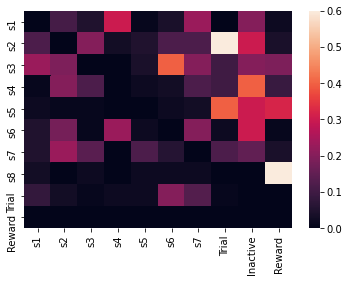

In [2]:
A =  np.array([(0, 0.11, 0.05, 0.3, 0.01,0.04, 0.23, 0.0, 0.2, 0.02),
               (0.12, 0, 0.2, 0.03, 0.05,0.12, 0.12, 0.6, 0.3, 0.04),
               (0.23, 0.19, 0, 0, .04,0.4, 0.2, 0.1, 0.2, 0.19),
               (0.01, 0.2, 0.12, 0, 0.02,0.03, 0.12, 0.1, 0.4, 0.09),
               (0.02, 0.01, 0.01, 0, 0,0.02, 0.03, 0.4, 0.3, 0.32),
               (0.05, 0.18, 0.01, 0.23, 0.02,0, 0.2, 0.02, 0.30, 0.01),
               (0.05, 0.23, 0.14, 0.0, 0.12,0.06, 0, 0.12, 0.15, 0.04),
               (0.03, 0.0, 0.02, 0.0, 0.02,0.02, 0.02, 0, 0, 0.60),
               (0.08, 0.03, 0.01, 0.02, 0.02,0.2, 0.13, 0.01, 0, 0.001),
               (0, 0, 0, 0, 0,0, 0, 0, 0, 0,)
               ]) 

Transition_Prob = np.asmatrix(A)
P = pd.DataFrame(Transition_Prob, columns = ['s1','s2','s3','s4','s5','s6','s7','Trial','Inactive','Reward'], 
                 index=['s1','s2','s3','s4','s5','s6','s7','s8','Trial','Reward'])
#Probability Matrix
display(P)
#Heatmap
print(sn.heatmap(P))

In [ ]:
*Visualize Graph Network():*

The network graph below represents the nodes and weighted edges(based on transition probabilities in matrix (P). Distance of edges between nodes are inversely related  to the respective transition probabilities. (i.e. the closer 2 nodes  or states(s) are together, the higher the probability of transitioning to and from those states(s).


In [ ]:
G = nx.DiGraph()
G.add_nodes_from(range(1,10))
slist = {1:'s1', 2:'s2',3:'s3',4:'s4',5:'s5',6:'s6',7:'s7',8:'Trial',9:'Inactive',10:'Paid Sub!'}
h1 = np.arange(1,10)
i1 = np.arange(1,11)
for h in h1:
    for i in i1:
      if i != h:
        w = A[h-1,i-1]

        G.add_edge(h, i, weight= w , scale = 2)

        pos=nx.spring_layout(G,scale=2)
        color_map = ['#A0CBE2', '#A0CBE2', '#A0CBE2', '#A0CBE2', '#A0CBE2', '#A0CBE2', '#A0CBE2', 'orange', 'red', 'green' ]
        nx.draw(G,node_color = color_map, node_size = 800, labels = slist)

*Create Reward Function(R) for all states in (S) and Generate Optimal Value for Each State:*

The reward function below is shown in a 10x10 matrix R. Each value in matrix r[i, j] corresponds with a “reward” weight used in the Value Iteration algorithm for that respective state at s[i, j]. 

The example I used below is simple, where weights are either -1, 0, or 1.  However, we can use actual values of subscription, and the model should ‘values’ should scale with the reward weights (r). 



,s1,s2,s3,s4,s5,s6,s7,s8,Inactive,Reward
s1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Inactive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


AxesSubplot(0.125,0.125;0.496x0.755)


,s1,s2,s3,s4,s5,s6,s7,s8,Inactive,Reward
s1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Inactive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


AxesSubplot(0.125,0.125;0.31744x0.755)


,s1,s2,s3,s4,s5,s6,s7,s8,Inactive,Reward
s1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Inactive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


AxesSubplot(0.125,0.125;0.203162x0.755)


,s1,s2,s3,s4,s5,s6,s7,s8,Inactive,Reward
s1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Inactive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


AxesSubplot(0.125,0.125;0.130023x0.755)


,s1,s2,s3,s4,s5,s6,s7,s8,Inactive,Reward
s1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Inactive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


AxesSubplot(0.125,0.125;0.083215x0.755)


,s1,s2,s3,s4,s5,s6,s7,s8,Inactive,Reward
s1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Inactive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


AxesSubplot(0.125,0.125;0.0532576x0.755)


,s1,s2,s3,s4,s5,s6,s7,s8,Inactive,Reward
s1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Inactive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


AxesSubplot(0.125,0.125;0.0340849x0.755)


,s1,s2,s3,s4,s5,s6,s7,s8,Inactive,Reward
s1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
Inactive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


AxesSubplot(0.125,0.125;0.0218143x0.755)


,s1,s2,s3,s4,s5,s6,s7,s8,Inactive,Reward
s1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
s8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
Inactive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
NA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


AxesSubplot(0.125,0.125;0.0139612x0.755)


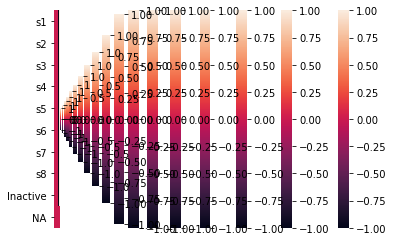

In [7]:
#Reward Function.
reward_function_1 = np.zeros((10,10))

for i in np.arange(9):
  reward_function_1[i,9] = 1
  reward_function_1[i,8] = -1
  #print(reward_function_1)
  x = np.arange(10)
  y = -1*x
  yvalues = np.arange(1,10)
  sn.heatmap(reward_function_1)
  P = pd.DataFrame(reward_function_1, columns = ['s1','s2','s3','s4','s5','s6','s7','s8','Inactive','Reward'],
  index=['s1','s2','s3','s4','s5','s6','s7','s8','Inactive','NA'])
  #Probability Matrix
  display(P)
  #Heatmap
  print(sn.heatmap(P))

This is the space that your “Agent” will walk through to calculate transition probabilities (P).  The actions (a) are confined to moving within the state space.  There are 10 possible states(s) that exist in our model, and the value of each state will be stored in an array below.  *The structure of the state space is flexible and can be represented in numerous ways.



In [5]:
state_space = np.zeros((1,10))

for i in range(1):
  for j in range(10):
    state_space[i,j] = j + i

display(state_space)

array([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]])

*Create Value Iteration Function and Generate Optimal Value for Each State:*

The Value Iteration algorithm will loop through all states and finds the maximum conditional probability of each state (s), for all actions (a).  The algorithm continues to loop through until the difference between the values of (s) at each iteration converge.  We use a discount factor (d) to enable the algorithm to converge.  The below python code constructs the Value Iteration Algorithm below (from lines 11-13).  The values (v) outputted from these steps represent the expected value after considering all all actions (A) between the Agent and Environment (E), for all states (S) and reward function (R). Lines 15-17 returns the optimal actions associated with these values (v), which will be the next step. 

We use a discount factor (d) of 0.8, which enable the algorithm to converge. The algorithm below ran for 6 iterations, setting Delta = 0.01

For more information about Value Iteration click here (https://artint.info/html/ArtInt_227.html)


In [ ]:
  # Initialization of Value State Space
    vs = np.zeros(np.shape(s))
    #build probabiltiy matrix based on 10 X 10 matrix
    vsp = np.zeros([10,10])
    delta = 1000  
    counter = 0
  # Estimation Loop
    # run until convergence
    while delta > 0.001:
        delta = 0
        
        # only 1 row in state space.
        for i in range(1):
            # walk across each state iterator
            
            j = np.arange(9)
            for j in j:
            
                    #  set current value to latest vs value state
                    v = vs[i,j]   
                    # defined action states for each state.  
                    if j == 0:
                      actionset =  [(j,1), (j,2), (j,3),(j,4),(j,5), (j,6), (j,7),(j,8), (j,9)]
                    elif j == 1:
                      actionset = [(j,0), (j,2), (j,3),(j,4),(j,5), (j,6), (j,7),(j,8), (j,9)]
                    elif j == 2:
                      actionset = [(j,0), (j,1), (j,3),(j,4),(j,5), (j,6), (j,7),(j,8), (j,9)]
                    elif j == 3:
                      actionset = [(j,0), (j,2), (j,1),(j,4),(j,5), (j,6), (j,7),(j,8), (j,9)]
                    elif j == 4:
                      actionset = [(j,0), (j,2), (j,3),(j,1),(j,5), (j,6), (j,7),(j,8), (j,9)]
                    elif j == 5:
                      actionset = [(j,0), (j,2), (j,3),(j,4),(j,1), (j,6), (j,7),(j,8), (j,9)]
                    elif j == 6:
                      actionset = [(j,0), (j,2), (j,3),(j,4),(j,5), (j,1), (j,7),(j,8), (j,9)]
                    elif j == 7:
                      actionset = [(j,0), (j,2), (j,3),(j,4),(j,5), (j,6), (j,1),(j,8), (j,9)]
                    elif j == 8:
                      actionset = [(j,0), (j,2), (j,3),(j,4),(j,5), (j,6), (j,7),(j,1), (j,9)]
                    #elif j == 9:
                    k = 0         
                    # walk through each actionstep to get the rdv : Reward Function + Discount * latest vs value
                    sump = 0
                    for a in actionset:
                        x = 0 + (a[0])
                        y = (a[1])
                        
                        # get transition probability 
                        p = A[x,y]
                    #1.get the value based on possible actions of each state. #discount factor provides a finite solution, per MDP process
                        rdv = r[x,y] + d * vs[i,a[1]]
                    #2.  Get the probablity-weighted value, and add sum for entire state.
                        sump = sump + p * rdv
                        vsp[j,a[1]] = p * rdv
                        #print([i,j], [i,y], [i,a[1]], vs[i,j],p, rdv, sump)
                        #iterate do run through all actions
                        k += 1

          # print('\n')  # if the sum of all action sets is larger than current vs state score, then update with sump
                    if sump > vs[i,j]: 
                        vs[i,j] = sump
                        
                        
                    #print(sump , vs[i,j])
                    
                    # keep looping until change between previous vs is very small
                    delta = max([delta, abs(v-abs(vs[i,j]))])
                   
                    #print(delta)
                 #print(vs)
        counter +=1
    return vs , counter, vsp


# set 
discount_factor = 0.8
#run Value Iteration Function
vs , counter , vsp = value_iteration(reward_function_1, state_space, 
                     discount_factor, w, actionset)
v = np.arange(9)

vs1 = []

for v in v:

    vs1.append(vs[0,v])

print(vs1)

plt.title('Optimal State value')
y = np.arange(9)
plt.scatter(y , vs1)
plt.xticks(np.arange(9), ('s1', 's2', 's3', 's4', 's5', 's6', 's7', 'Trial', 'Inactive'))
plt.ylabel('max value (v) for state (s)')

plt.show()
vsp = pd.DataFrame(vsp, columns = ['s1','s2','s3','s4','s5','s6','s7','Trial','Inactive','Reward'], 
                 index=['s1','s2','s3','s4','s5','s6','s7','Trial','Inactive','Reward'])
sn.heatmap(vsp)

*Create Optimal Value Function and* *Generate Next Best Action by State(s):*

The output below is the estimated “next best step”, based on the previous Value Iteration() Function output above (lines 14-17).  The output can also be referred to as the optimal policy (pi).  



In [ ]:
# Create computation of values based on Agent Actions, what is the Optimal Next Step?

def vi_computation(vs, r, s, d, w):
      pi = np.zeros(np.shape(s))
  
      for i in range(1):


        for j in range(9):
            amax = -10000
            if j == 0:
              actionset =  [(j,1), (j,2), (j,3),(j,4),(j,5), (j,6), (j,7),(j,8)]
            elif j == 1:
              actionset = [(j,0), (j,2), (j,3),(j,4),(j,5), (j,6), (j,7),(j,8)]
            elif j == 2:
              actionset = [(j,0), (j,1), (j,3),(j,4),(j,5), (j,6), (j,7),(j,8)]
            elif j == 3:
              actionset = [(j,0), (j,2), (j,1),(j,4),(j,5), (j,6), (j,7),(j,8)]
            elif j == 4:
              actionset = [(j,0), (j,2), (j,3),(j,1),(j,5), (j,6), (j,7),(j,8)]
            elif j == 5:
              actionset = [(j,0), (j,2), (j,3),(j,4),(j,1), (j,6), (j,7),(j,8)]
            elif j == 6:
              actionset = [(j,0), (j,2), (j,3),(j,4),(j,5), (j,1), (j,7),(j,8)]
            elif j == 7:
              actionset = [(j,0), (j,2), (j,3),(j,4),(j,5), (j,6), (j,1),(j,8)]
            elif j == 8:
              actionset = [(j,0), (j,2), (j,3),(j,4),(j,5), (j,6), (j,7),(j,1)]
         
            sump = 0
            for a in actionset:
                x = 0 + (a[0])
                y = (a[1])

 # get transition probability. Create computation of values based on Agent Actions, what is the Optimal Next Step?

def vi_computation(vs, r, s, d, w):
      pi = np.zeros(np.shape(s))
  
      for i in range(1):


        for j in range(9):
            amax = -10000
            if j == 0:
              actionset =  [(j,1), (j,2), (j,3),(j,4),(j,5), (j,6), (j,7),(j,8)]
            elif j == 1:
              actionset = [(j,0), (j,2), (j,3),(j,4),(j,5), (j,6), (j,7),(j,8)]
            elif j == 2:
              actionset = [(j,0), (j,1), (j,3),(j,4),(j,5), (j,6), (j,7),(j,8)]
            elif j == 3:
              actionset = [(j,0), (j,2), (j,1),(j,4),(j,5), (j,6), (j,7),(j,8)]
            elif j == 4:
              actionset = [(j,0), (j,2), (j,3),(j,1),(j,5), (j,6), (j,7),(j,8)]
            elif j == 5:
              actionset = [(j,0), (j,2), (j,3),(j,4),(j,1), (j,6), (j,7),(j,8)]
            elif j == 6:
              actionset = [(j,0), (j,2), (j,3),(j,4),(j,5), (j,1), (j,7),(j,8)]
            elif j == 7:
              actionset = [(j,0), (j,2), (j,3),(j,4),(j,5), (j,6), (j,1),(j,8)]
            elif j == 8:
              actionset = [(j,0), (j,2), (j,3),(j,4),(j,5), (j,6), (j,7),(j,1)]
         
            sump = 0
            for a in actionset:
                x = 0 + (a[0])
                y = (a[1])

        # get transition probability 
                p = A[x,y]
        #1.get the value based on possible actions of each state. #discount factor provides a finite solution, per MDP process
                rdv = r[x,y] + d * vs[i,a[1]]
        #2.  Get the probablity-weighted value, and add sum for entire state.
                sump = sump + p * rdv

                #print([i,j], [i,y], [i,a[1]], vs[i,j],p, rdv, sump)
                #iterate do run through all actions
                #k += 
        # now comparing against argument max()
                if sump > amax: 
                  amax = sump
                  #print(sump) 
                  #print(a)
                  # To get the optimal action

                  pi[i,j] = a[1]
          
        return pi
    
# Optimal Values
pi = vi_computation(vs, reward_function_1, state_space, 
                    discount_factor, w)
#print(pi)
v = np.arange(9)
vs1 = []
for v in v:
    vs1.append(pi[0,v])
    

print(vs1)

plt.title('Optimal Next Step')
y = np.arange(9)
plt.scatter(y , vs1)
plt.xticks(np.arange(9), ('s1', 's2', 's3', 's4', 's5', 's6', 's7', 'Trial', 'Inactive'))
plt.ylabel('Optimal Next Step for State (s)')
plt.scatter
                p = A[x,y]
            #1.get the value based on possible actions of each state. #discount factor provides a finite solution, per MDP process
                rdv = r[x,y] + d * vs[i,a[1]]
            #2.  Get the probablity-weighted value, and add sum for entire state.
                sump = sump + p * rdv

                #print([i,j], [i,y], [i,a[1]], vs[i,j],p, rdv, sump)
                #iterate do run through all actions
                #k += 
        # now comparing against argument max()
                if sump > amax: 
                  amax = sump
                  #print(sump) 
                  #print(a)
                  # To get the optimal action

                  pi[i,j] = a[1]
          
        return pi
    
# Optimal Values
pi = vi_computation(vs, reward_function_1, state_space, 
                    discount_factor, w)
#print(pi)
v = np.arange(9)
vs1 = []
for v in v:
    vs1.append(pi[0,v])
    

print(vs1)

plt.title('Optimal Next Step')
y = np.arange(9)
plt.scatter(y , vs1)
plt.xticks(np.arange(9), ('s1', 's2', 's3', 's4', 's5', 's6', 's7', 'Trial', 'Inactive'))
plt.ylabel('Optimal Next Step for State (s)')
plt.scatter